In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [21]:
def wrangle(filepath):
    df = pd.read_csv(filepath).set_index("timestamp")
    # Localize timezone
    df.index = pd.to_datetime(df.index)
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    # Remove outliers
    df = df[df["P2"] < 100]
    # Resample and forward-fill
    y = df["P2"].resample("1H").mean().fillna(method="ffill")
    
    return y

In [31]:
y = wrangle("data/Nairobi.csv")
y.head()

C:\Users\zhongyanmin\AppData\Local\Temp\ipykernel_1032\1050913634.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = df["P2"].resample("1H").mean().fillna(method="ffill")
C:\Users\zhongyanmin\AppData\Local\Temp\ipykernel_1032\1050913634.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df["P2"].resample("1H").mean().fillna(method="ffill")


timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: h, Name: P2, dtype: float64

### Explore Data

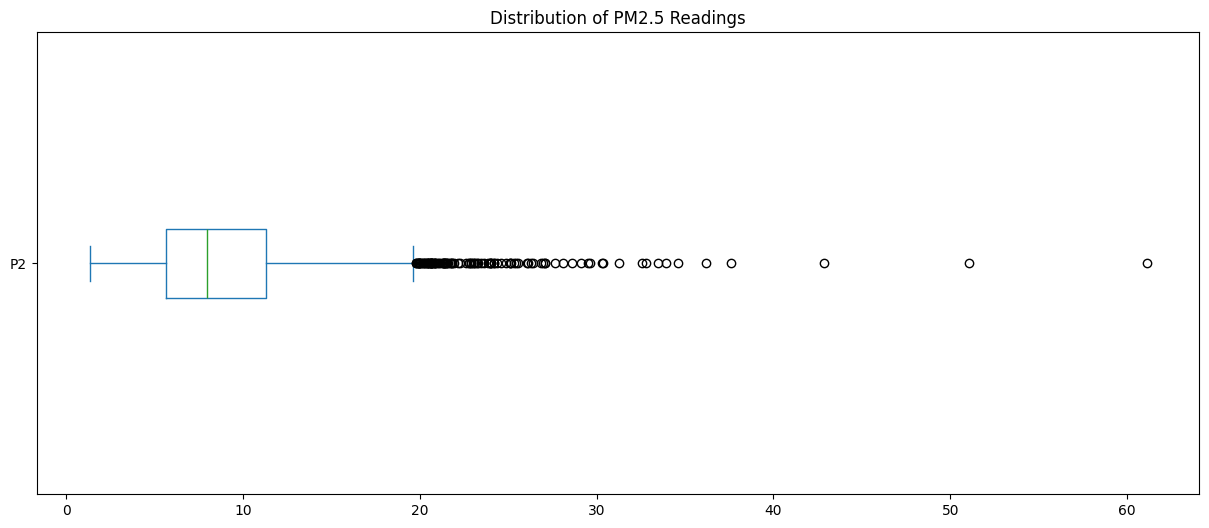

In [32]:
# Create boxplot
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);

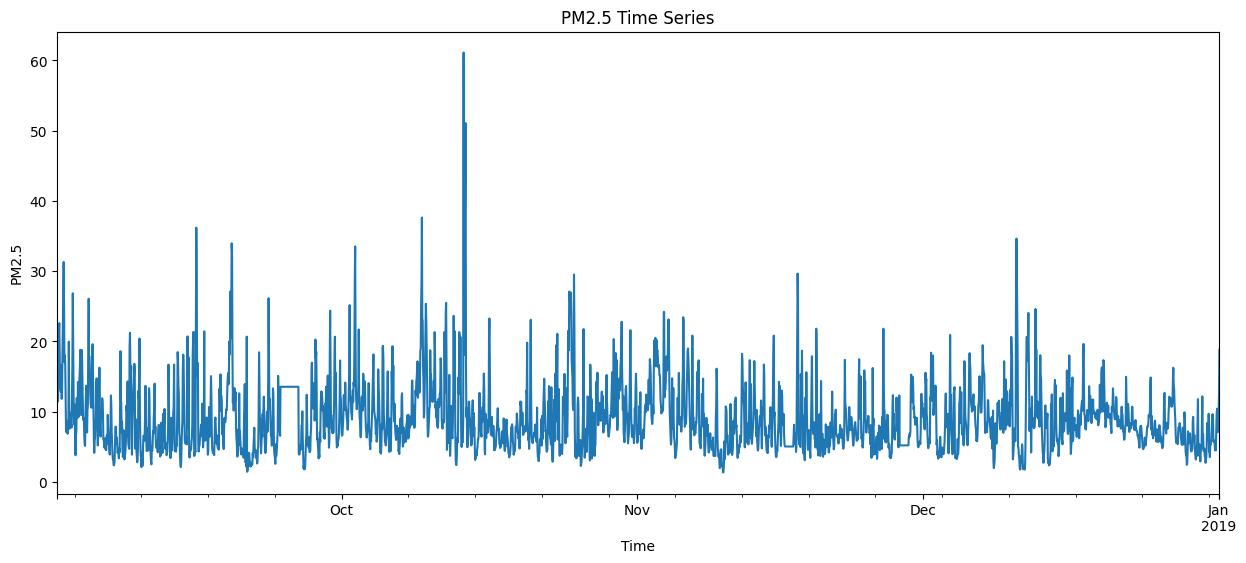

In [33]:
# Create time series plot
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel= "Time",ylabel= "PM2.5", title= "PM2.5 Time Series",ax=ax);

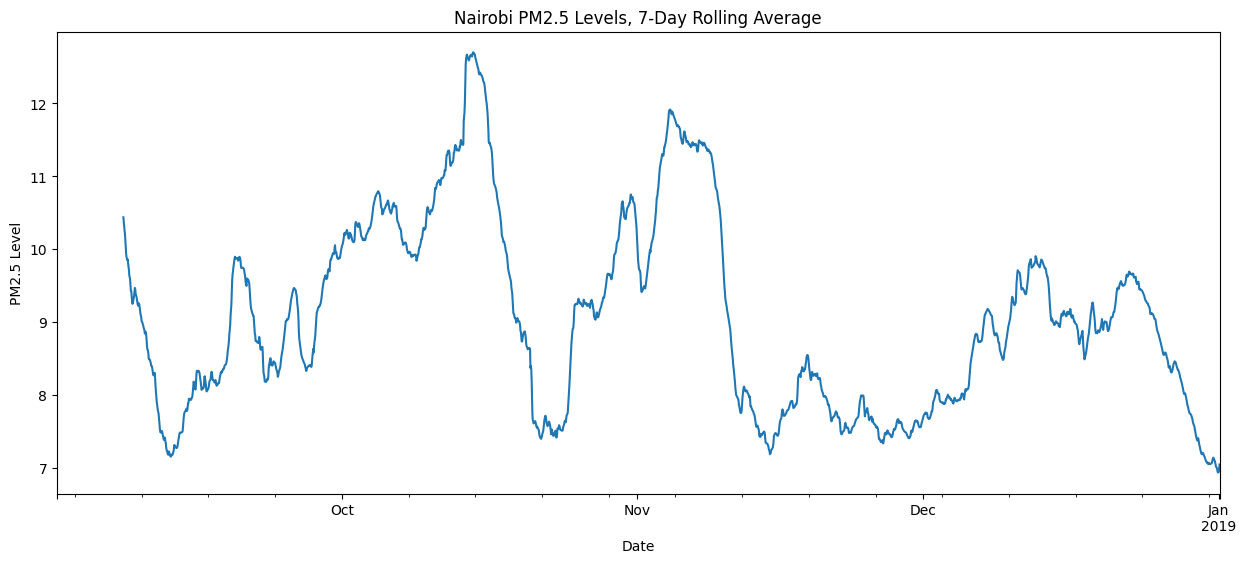

In [34]:
# Create the rolling average Plot
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Nairobi PM2.5 Levels, 7-Day Rolling Average");

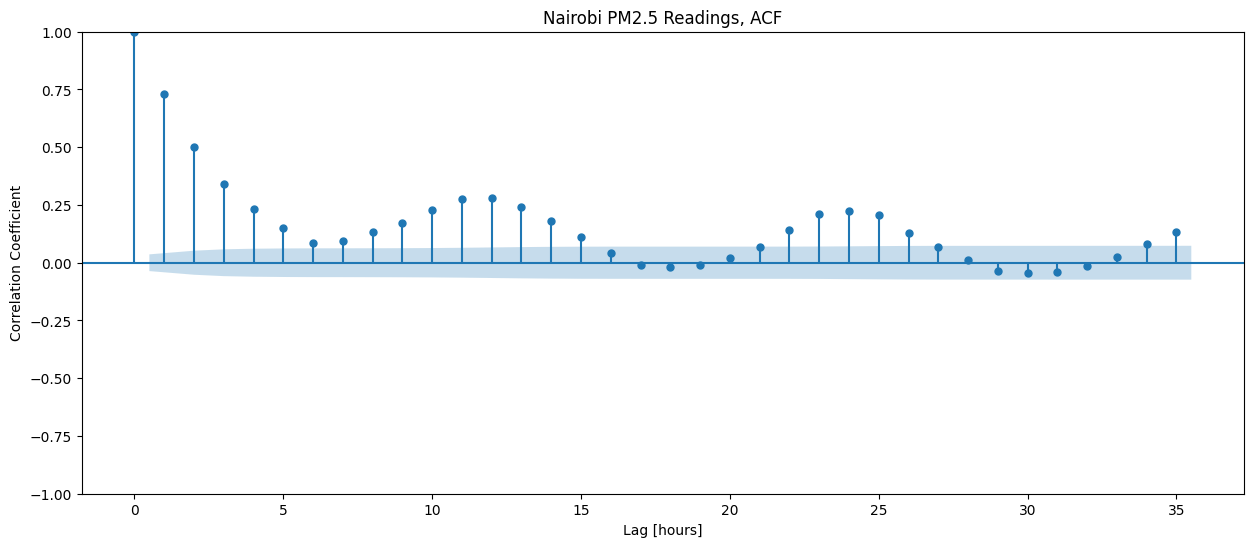

In [35]:
# Create ACF plot
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Nairobi PM2.5 Readings, ACF");

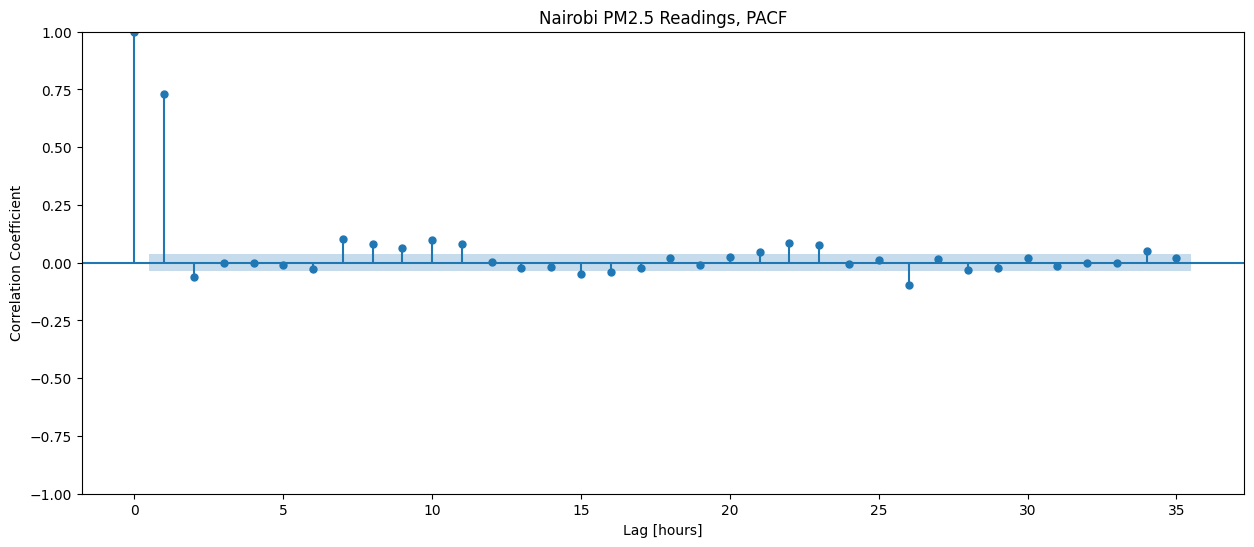

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Nairobi PM2.5 Readings, PACF");

### Split Data

In [38]:
cutoff_test = int(len(y) * 0.9)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (2635,)
y_test shape: (293,)


### Build Model

#### Baseline

In [39]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 9.231055100581477
Baseline MAE: 3.779334549916476


#### Iterate

In [40]:
# Create range to test different lags
p_params = range(1, 31)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model = AutoReg(y_train, lags=p).fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model.predict().dropna()

    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    # Append `mae` to list `maes`
    maes.append(mae)

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
mae_series.head()

1    2.303623
2    2.294843
3    2.294797
4    2.294474
5    2.292110
Name: mae, dtype: float64

In [41]:
best_p = mae_series.idxmin()
best_model = AutoReg(y_train, lags=best_p).fit()

In [42]:
y_train_resid = model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-09-02 09:00:00+03:00    10.352227
2018-09-02 10:00:00+03:00    -7.216859
2018-09-02 11:00:00+03:00    -1.251572
2018-09-02 12:00:00+03:00     2.746879
2018-09-02 13:00:00+03:00     0.510420
Freq: h, Name: residuals, dtype: float64

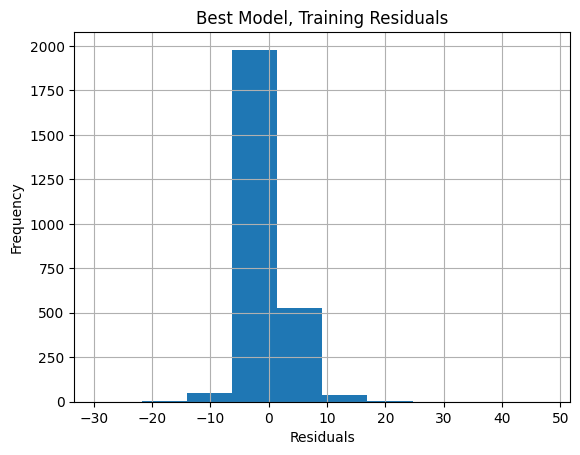

In [43]:
# Plot histogram of residuals
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals");

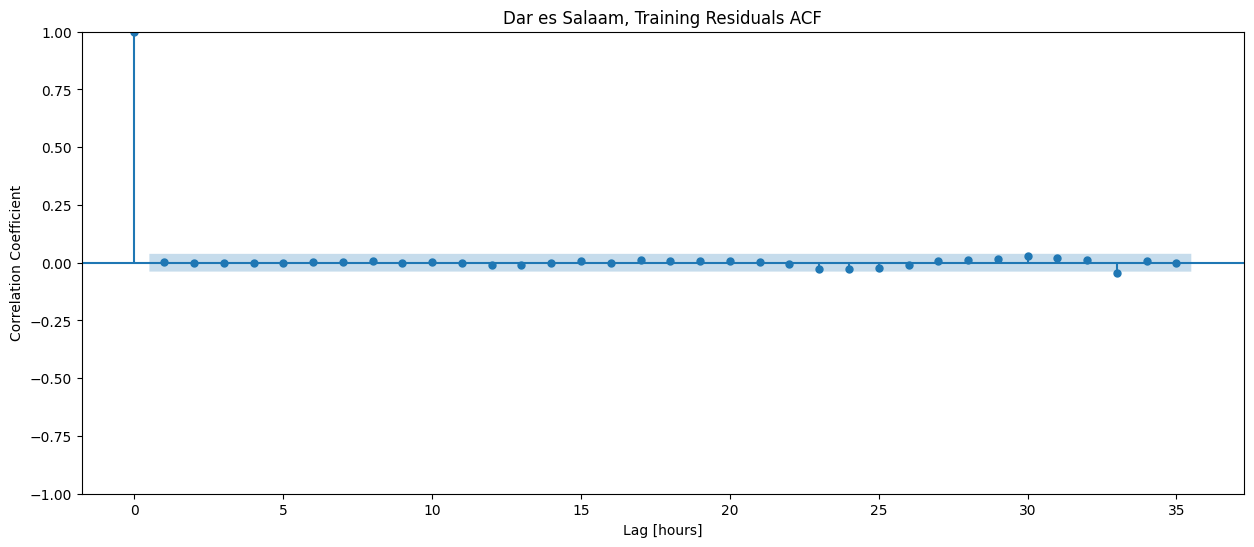

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam, Training Residuals ACF");

### Evaluate

In [100]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.add(next_pred, fill_value=0)
    history = history.add(y_test[next_pred.index], fill_value=0)

### Communicate Results

In [106]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred_wfv": y_pred_wfv
    },
    index = y_test.index
)
df_pred_test["y_pred_wfv"] = df_pred_test["y_pred_wfv"].astype(float)
fig = px.line(df_pred_test, labels={"value": "PM2.5"})
fig.update_layout(
    title="Nairobi, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)

fig.show()